# Basic Causal Structures

Understanding basic causal structures is crucial in causal inference because they possess **unique properties** that aid in the discovery of causal graphs from observational data. Additionally, recognizing these structures is essential for correctly specifying **regression models** in statistical analysis. Misidentifying or incorrectly including variables based on these structures can lead to erroneous conclusions and model estimates.

## Chains

A chain occurs when one variable causally affects a second, which in turn affects a third. This linear sequence shows the **transmission of causality** through an intermediary.

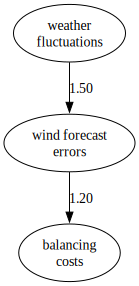

In [1]:
import numpy as np
from lingam.utils import make_dot

# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [1.5, 0.0, 0.0],
              [0.0, 1.2, 0.0]])

# Plotting causal graph
make_dot(m, labels=["weather \nfluctuations", "wind forecast \nerrors", "balancing \ncosts"])

This causal graph represents the following **structural causal model (SCM)**:

\begin{align}
\text{weather fluctuations} &= e_w \\
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\text{balancing costs} &= 1.2 \times \text{wind forecast errors} + e_b \\
\end{align}

where the **coefficients** 1.5 and 1.2 represent the strenghts of the causal connections.

In this case, the **causal association flows** from the weather forecast to the balancing costs, and is (fully) **mediated** by the wind forecast errors.

## Forks

A fork occurs when a single variable causally influences two other variables, making it a common cause to both. This structure typically indicates that the two downstream variables are **correlated due to a shared source** but do not causally influence each other. This coincides with the exmaple we saw in the previous chapter, where the common cause (temperature) gave the impression that electricity load and ice cream sales were correlated.

Another example, related to the balancing costs in the electricity markets, might be the effect of weather fluctuations on wind forecast errors and on electricity load due to increase heating (or cooling) demand.

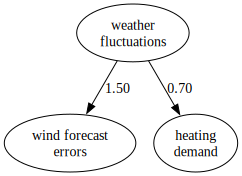

In [2]:
# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [1.5, 0.0, 0.0],
              [0.7, 0.0, 0.0]])

# Plotting causal graph
make_dot(m, labels=["weather \nfluctuations", "wind forecast \nerrors", "heating \ndemand"])

This causal graph represents the following **SCM**:

\begin{align}
\text{weather fluctuations} &= e_w \\
\text{wind forecast errors} &= 1.5 \times \text{weather flucturations} + e_f \\
\text{heating demand costs} &= 0.7 \times \text{heating demand} + e_h \\
\end{align}

where $e_w, e_f, e_h \sim \mathcal{N}(0,1)$.

First, let's generate some data from this DAG.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Setting a random seed for reproducibility
np.random.seed(42)

# Generating synthetic data
n = 100000
weather_fluctuations = np.random.normal(0, 1, n)  # average temperature in Celsius
forecast_errors = 1.5 * weather_fluctuations + np.random.normal(0, 1, n)  # Quadratic relationship for U-shape
heating = 0.7* weather_fluctuations + np.random.normal(0, 1, n)  # also influenced by temperature

# Creating a DataFrame
data = pd.DataFrame({'weather': weather_fluctuations, 'forecast errors': forecast_errors, 'heating demand': heating})

data.head()

,weather,forecast errors,heating demand
0,0.496714,1.775666,1.909541
1,-0.138264,-1.362751,-0.191013
2,0.647689,1.546970,-0.876154
3,1.523030,1.665306,-0.322517
4,-0.234153,-0.678633,-0.506558


Now, let's plot the pairwise correlation plots.

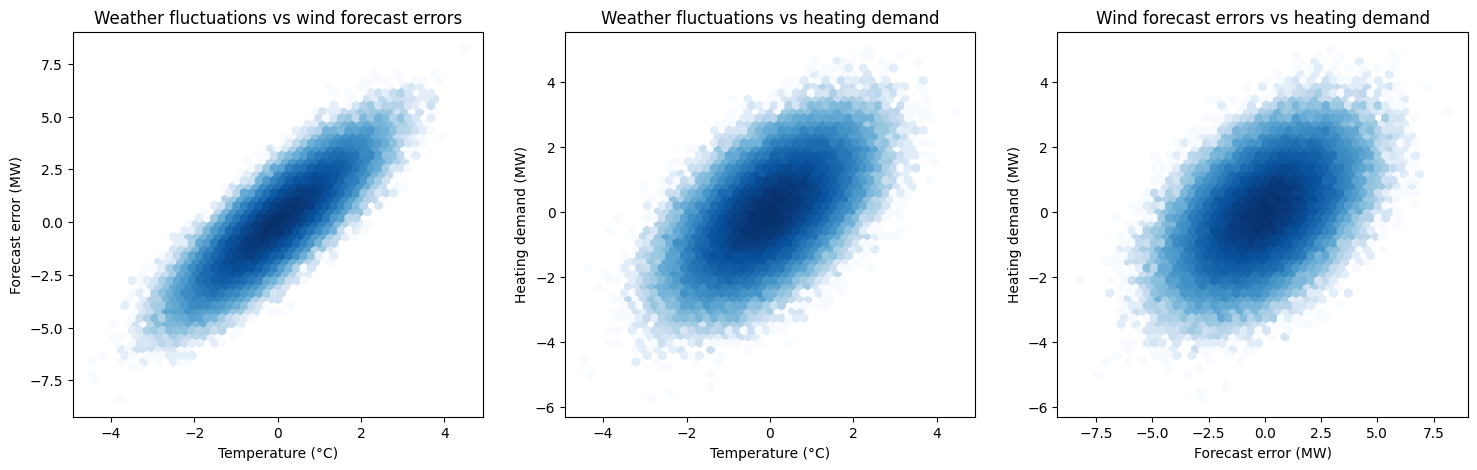

In [4]:
# Setting up the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature vs Electricity Load with hexbin plot
hb1 = axes[0].hexbin(data['weather'], data['forecast errors'], gridsize=50, cmap='Blues', bins='log')
axes[0].set_title('Weather fluctuations vs wind forecast errors')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Forecast error (MW)')

# Temperature vs Ice Cream Sales with hexbin plot
hb2 = axes[1].hexbin(data['weather'], data['heating demand'], gridsize=50, cmap='Blues', bins='log')
axes[1].set_title('Weather fluctuations vs heating demand')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('Heating demand (MW)')

# Electricity Load vs Ice Cream Sales with hexbin plot
hb3 = axes[2].hexbin(data['forecast errors'], data['heating demand'], gridsize=50, cmap='Blues', bins='log')
axes[2].set_title('Wind forecast errors vs heating demand')
axes[2].set_xlabel('Forecast error (MW)')
axes[2].set_ylabel('Heating demand (MW)')

plt.show()

We can see that, despites **not being causally related**, wind forecast errors and heating demand appears to be **positively correlated**. This is because they have a **common cause**, represented by the weather fluctuations.

## Immoralities

An immorality happens when two variables independently cause a third variable, but there is no causal connection between the two independent variables. Conditioning on the common effect (**collider**) can introduce a **spurious association** between these independent variables.

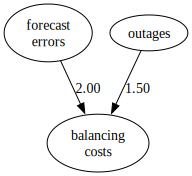

In [5]:
# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0],
              [2.0, 1.5, 0.0]])

# Plotting causal graph
make_dot(m, labels=["forecast \nerrors", "outages", "balancing \ncosts"])

This causal graph represents the following **SCM**:

\begin{align}
\text{forecast errors} &= e_f \\
\text{outages} &= e_o \\
\text{balancing costs} &= 2 \times \text{forecast errors} + 1.5 \times \text{outages} + e_b \\
\end{align}

where $e_f, e_o, e_b \sim \mathcal{N}(0,1)$.

We will now see the effect of the **Berkson's paradox**, which is the spurious correlation observed in the two parent variables, after conditioning on the collider. 

First, let's generate some data.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(42)

# Generate data for the Immorality example
n = 100000
forecast_errors = np.random.normal(0, 1, n)
outages = np.random.normal(0, 1, n)
balancing_costs = 2 * forecast_errors + 1.5 * outages + np.random.normal(0, .1, n)  # the collider

data_immorality = pd.DataFrame({'forecast errors': forecast_errors, 'outages': outages, 'balancing costs': balancing_costs})

data_immorality.head()

,forecast errors,outages,balancing costs
0,0.496714,1.030595,2.695504
1,-0.138264,-1.155355,-2.018984
2,0.647689,0.575437,2.025579
3,1.523030,-0.619238,1.978338
4,-0.234153,-0.327403,-0.993676


Now, let's take a look at the correlations, after conditioning on the child variable.

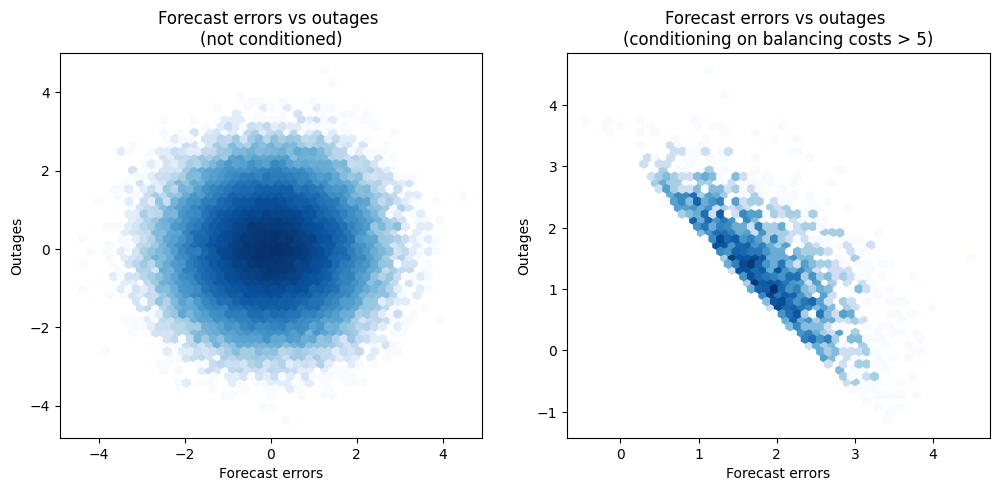

In [7]:
# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(data_immorality['forecast errors'], data_immorality['outages'], gridsize=50, cmap='Blues', bins='log')
# cb1 = fig.colorbar(hb1, ax=axes[0])
axes[0].set_title('Forecast errors vs outages \n(not conditioned)')
axes[0].set_xlabel('Forecast errors')
axes[0].set_ylabel('Outages')

# After conditioning
data_immorality_conditioned = data_immorality[data_immorality['balancing costs'] >= 5]
hb2 = axes[1].hexbin(data_immorality_conditioned['forecast errors'], data_immorality_conditioned['outages'], gridsize=50, cmap='Blues', bins='log')
# cb2 = fig.colorbar(hb2, ax=axes[1])
axes[1].set_title('Forecast errors vs outages \n(conditioning on balancing costs > 5)')
axes[1].set_xlabel('Forecast errors')
axes[1].set_ylabel('Outages')

plt.show()

We can observe how conditioning on a collider introduces spurious correlations in the data. Outages and forecast errors are **not causally related** but, when conditioning on the balancing costs, they **appear to be correlated**.


This underscores the importance of being cautious when attempting to draw causal conclusions from observational data. 

**In practice**, this means that merely including the collider as a predictor in a **regression model** can lead to misleading results, where the estimated coefficients deviate significantly from the true causal effects. This potential misstep highlights the necessity of carefully selecting variables for inclusion in regression models, especially when the goal is to uncover causal relationships rather than mere associations.